In [15]:
# Imports
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1. Chargement et Exploration des Données

In [16]:
# Charger le dataset
# Option 1: Dataset original (85 vidéos uniquement)
# dataset_path = Path("../data/processed/keypoints/exercise_dataset.json")

# Option 2: Dataset enrichi (vidéos + images - RECOMMANDÉ)
dataset_path = Path("../data/processed/keypoints/exercise_dataset_complete.json")

with open(dataset_path, 'r') as f:
    dataset = json.load(f)

print(f"Dataset chargé: {len(dataset)} éléments")

# Séparer vidéos et images
videos = [d for d in dataset if not d.get('is_image', False)]
images = [d for d in dataset if d.get('is_image', False)]

print(f"  - Vidéos: {len(videos)}")
print(f"  - Images: {len(images)}")
print(f"\nPremière entrée:")
print(f"  Nom: {dataset[0]['video_name']}")
print(f"  Label: {dataset[0]['label']}")
print(f"  Frames détectées: {dataset[0]['detected_frames']}")
print(f"  Type: {'Image' if dataset[0].get('is_image', False) else 'Vidéo'}")
print(f"  Features par frame: {len(dataset[0]['sequence'][0]) - 1}")  # -1 pour frame_num

Dataset chargé: 1404 éléments
  - Vidéos: 85
  - Images: 1319

Première entrée:
  Nom: push-up_1.mp4
  Label: pushup
  Frames détectées: 150
  Type: Vidéo
  Features par frame: 99



Distribution des classes:
squat     764
pushup    640
Name: count, dtype: int64


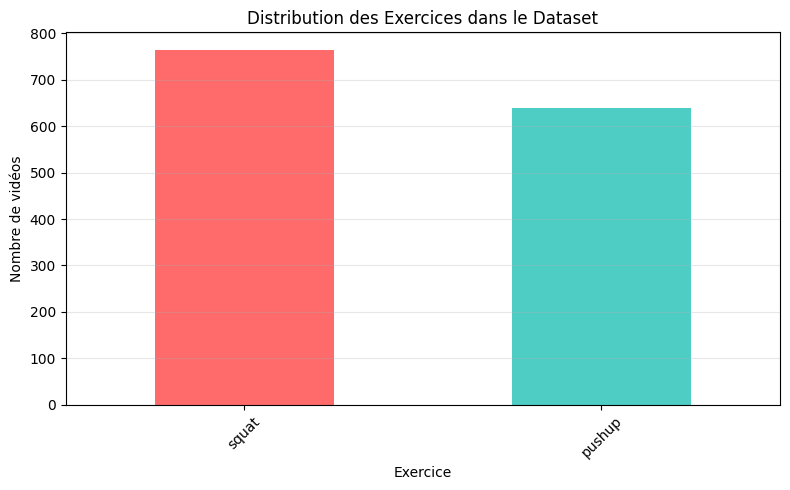

In [17]:
# Statistiques par classe
labels = [item['label'] for item in dataset]
label_counts = pd.Series(labels).value_counts()

print("\nDistribution des classes:")
print(label_counts)

# Visualiser
plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar', color=['#FF6B6B', '#4ECDC4'])
plt.title('Distribution des Exercices dans le Dataset')
plt.xlabel('Exercice')
plt.ylabel('Nombre de vidéos')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Préparation des Données

### Normalisation et Padding
- Les séquences ont des longueurs différentes
- On utilise le padding pour uniformiser
- On normalise les coordonnées

In [18]:
def prepare_sequences(dataset, max_sequence_length=None):
    """
    Prépare les séquences pour l'entraînement LSTM.
    Gère à la fois les vidéos (séquences longues) et images (1 frame).
    
    Returns:
        X: Array (n_samples, max_seq_len, n_features)
        y: Array (n_samples,) - labels encodés
        label_encoder: Encodeur des labels
        max_sequence_length: Longueur max utilisée
    """
    sequences = []
    labels = []
    
    # Extraire les séquences
    for item in dataset:
        sequence = item['sequence']
        
        # Convertir en array numpy
        frames = []
        for frame in sequence:
            # Extraire toutes les features sauf frame_num
            features = [v for k, v in frame.items() if k != 'frame_num']
            frames.append(features)
        
        sequences.append(np.array(frames))
        labels.append(item['label'])
    
    # Trouver la longueur maximale
    if max_sequence_length is None:
        max_sequence_length = max(len(seq) for seq in sequences)
    
    print(f"Longueur maximale de séquence: {max_sequence_length} frames")
    
    # Nombre de features
    n_features = sequences[0].shape[1]
    print(f"Nombre de features: {n_features}")
    
    # Statistiques sur les longueurs
    seq_lengths = [len(seq) for seq in sequences]
    print(f"\nDistribution des longueurs:")
    print(f"  Min: {min(seq_lengths)} frames")
    print(f"  Max: {max(seq_lengths)} frames")
    print(f"  Moyenne: {np.mean(seq_lengths):.1f} frames")
    print(f"  Médiane: {np.median(seq_lengths):.1f} frames")
    
    # Padding des séquences
    X = np.zeros((len(sequences), max_sequence_length, n_features))
    
    for i, seq in enumerate(sequences):
        seq_len = min(len(seq), max_sequence_length)
        X[i, :seq_len, :] = seq[:seq_len]
    
    # Encoder les labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(labels)
    
    print(f"\nClasses: {label_encoder.classes_}")
    print(f"Shape finale X: {X.shape}")
    print(f"Shape finale y: {y.shape}")
    
    return X, y, label_encoder, max_sequence_length

X, y, label_encoder, max_seq_len = prepare_sequences(dataset)

Longueur maximale de séquence: 778 frames
Nombre de features: 99

Distribution des longueurs:
  Min: 1 frames
  Max: 778 frames
  Moyenne: 14.0 frames
  Médiane: 1.0 frames

Classes: ['pushup' 'squat']
Shape finale X: (1404, 778, 99)
Shape finale y: (1404,)


In [19]:
# Split train/validation/test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train: {X_train.shape[0]} vidéos")
print(f"Validation: {X_val.shape[0]} vidéos")
print(f"Test: {X_test.shape[0]} vidéos")

Train: 982 vidéos
Validation: 211 vidéos
Test: 211 vidéos


## 3. Construction du Modèle LSTM

In [20]:
def create_lstm_model(input_shape, num_classes):
    """
    Crée un modèle LSTM pour la classification d'exercices.
    Architecture améliorée pour dataset plus large.
    
    Architecture:
    - Masking pour ignorer le padding
    - 2 couches LSTM bidirectionnelles (augmentées pour plus de données)
    - Dropout pour régularisation
    - Dense layers pour classification
    """
    model = keras.Sequential([
        # Masking: ignore les frames paddées (remplies de 0)
        layers.Masking(mask_value=0., input_shape=input_shape),
        
        # Première couche LSTM bidirectionnelle (augmentée: 64 -> 128)
        layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
        layers.Dropout(0.3),
        
        # Deuxième couche LSTM bidirectionnelle (augmentée: 32 -> 64)
        layers.Bidirectional(layers.LSTM(64)),
        layers.Dropout(0.3),
        
        # Couches denses (ajout d'une couche supplémentaire)
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        
        # Sortie
        layers.Dense(num_classes, activation='softmax' if num_classes > 2 else 'sigmoid')
    ])
    
    return model

# Créer le modèle
input_shape = (X_train.shape[1], X_train.shape[2])  # (max_seq_len, n_features)
num_classes = len(label_encoder.classes_)

model = create_lstm_model(input_shape, num_classes)

# Compiler avec learning rate adaptatif
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/mnt/d/SmartFit-Coach/venv/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 778, 99)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 778, 256)       │       233,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 778, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 408,226 (1.56 MB)

 Trainable params: 408,226 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Entraînement du Modèle

In [21]:
# Callbacks améliorés
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,  # Augmenté de 10 à 15
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,  # Augmenté de 5 à 7
        min_lr=1e-7,  # Plus bas pour convergence fine
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        '../models/exercise_classifier_lstm_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Entraîner avec plus d'epochs et batch_size ajusté
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # Augmenté de 50 à 100
    batch_size=16,  # Augmenté de 8 à 16 pour dataset plus large
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5746 - loss: 0.6574
Epoch 1: val_accuracy improved from None to 0.94787, saving model to ../models/exercise_classifier_lstm_best.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.6772 - loss: 0.5849 - val_accuracy: 0.9479 - val_loss: 0.2238 - learning_rate: 0.0010
Epoch 2/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8975 - loss: 0.2811
Epoch 2: val_accuracy improved from 0.94787 to 0.95735, saving model to ../models/exercise_classifier_lstm_best.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9012 - loss: 0.2684 - val_accuracy: 0.9573 - val_loss: 0.1275 - learning_rate: 0.0010
Epoch 3/100
60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9205 - loss: 0.2226
Epoch 3: val_accuracy did not improve from 0.95735
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9175 - loss: 0.2210 - val_accuracy: 0.9242 - val_loss: 0.2292 - learning_rate: 0.0010
Epoch 4/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9177 - loss: 0.2055
Epoch 4: val_accuracy improved from 0.95735 to 0.97156, saving model to ../models/exercise_classifier_lstm_best.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.9257 - loss: 0.1904 - val_accuracy: 0.9716 - val_loss: 0.0804 - learning_rate: 0.0010
Epoch 5/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9380 - loss: 0.1587
Epoch 5: val_accuracy improved from 0.97156 to 0.97630, saving model to ../models/exercise_classifier_lstm_best.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9389 - loss: 0.1616 - val_accuracy: 0.9763 - val_loss: 0.0650 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9511 - loss: 0.1215
Epoch 6: val_accuracy improved from 0.97630 to 0.99052, saving model to ../models/exercise_classifier_lstm_best.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.9532 - loss: 0.1359 - val_accuracy: 0.9905 - val_loss: 0.0510 - learning_rate: 0.0010
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9545 - loss: 0.1247
Epoch 7: val_accuracy did not improve from 0.99052
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.9470 - loss: 0.1430 - val_accuracy: 0.9905 - val_loss: 0.0425 - learning_rate: 0.0010
Epoch 8/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9675 - loss: 0.0989
Epoch 8: val_accuracy did not improve from 0.99052
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9705 - loss: 0.0940 - val_accuracy: 0.9858 - val_loss: 0.0481 - learning_rate: 0.0010
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9626 - loss: 0.1156
Epoch 9: val_accuracy did not improve from 0.99052
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9582 - loss: 0.1374 - val_accuracy: 0.9905 - val_loss: 0.0430 - learning_rate: 0.0010
Epoch 10/100
60/62 ━━━━━━━━━

62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9786 - loss: 0.0630 - val_accuracy: 1.0000 - val_loss: 0.0129 - learning_rate: 0.0010
Epoch 14/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9874 - loss: 0.0438
Epoch 14: val_accuracy did not improve from 1.00000
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9847 - loss: 0.0475 - val_accuracy: 1.0000 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 15/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9818 - loss: 0.0487
Epoch 15: val_accuracy did not improve from 1.00000
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.9817 - loss: 0.0508 - val_accuracy: 0.9953 - val_loss: 0.0232 - learning_rate: 0.0010
Epoch 16/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9638 - loss: 0.0979
Epoch 16: val_accuracy did not improve from 1.00000
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.9745 - loss: 0.0794 - val_accuracy: 0.9905 - val_loss: 0.0185 - learning_rate: 0.0010
Epoch 17/100
62/62 ━━

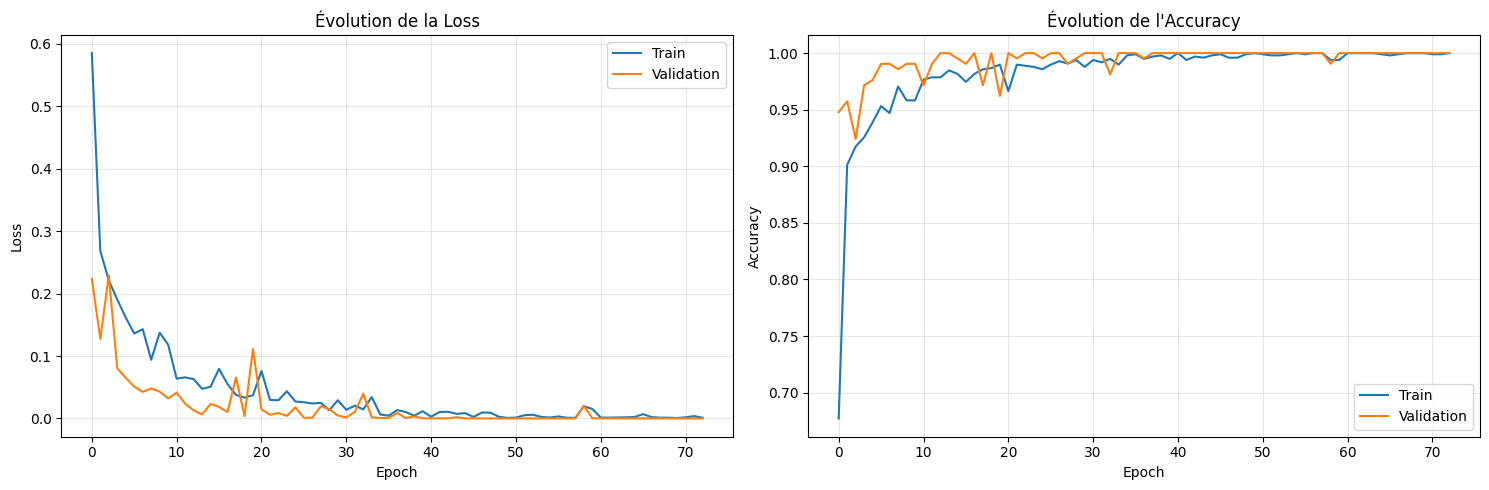

In [22]:
# Visualiser l'entraînement
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_title('Évolution de la Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Accuracy
ax2.plot(history.history['accuracy'], label='Train')
ax2.plot(history.history['val_accuracy'], label='Validation')
ax2.set_title('Évolution de l\'Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Évaluation sur le Test Set

In [23]:
# Évaluation
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_accuracy:.2%}")
print(f"Test Loss: {test_loss:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 1.0000 - loss: 8.1283e-05

Test Accuracy: 100.00%
Test Loss: 0.0001


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


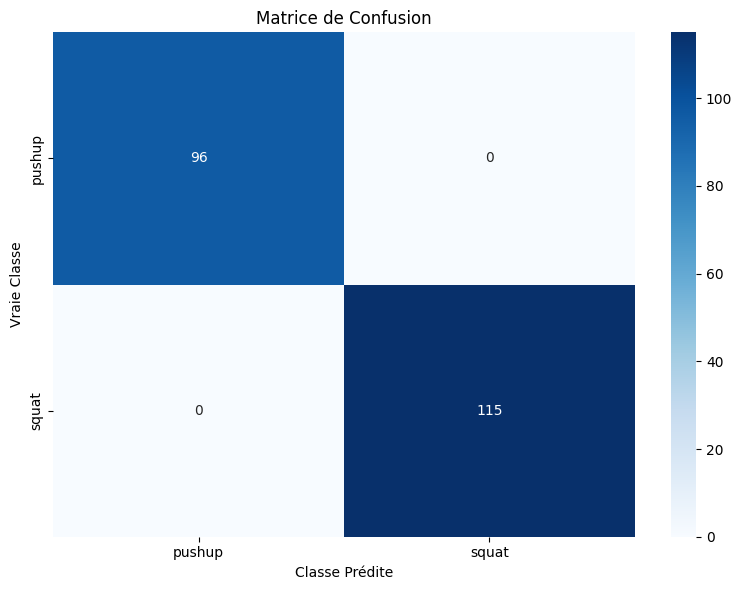


Rapport de Classification:
              precision    recall  f1-score   support

      pushup       1.00      1.00      1.00        96
       squat       1.00      1.00      1.00       115

    accuracy                           1.00       211
   macro avg       1.00      1.00      1.00       211
weighted avg       1.00      1.00      1.00       211



In [24]:
# Matrice de confusion
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Matrice de Confusion')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Prédite')
plt.tight_layout()
plt.show()

# Classification report
print("\nRapport de Classification:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

## 6. Sauvegarde du Modèle

In [25]:
# Créer le dossier models s'il n'existe pas
models_dir = Path("../models")
models_dir.mkdir(exist_ok=True)

# Sauvegarder le modèle
model_path = models_dir / "exercise_classifier_lstm.h5"
model.save(model_path)
print(f"Modèle sauvegardé: {model_path}")

# Sauvegarder les métadonnées
metadata = {
    "classes": label_encoder.classes_.tolist(),
    "max_sequence_length": int(max_seq_len),
    "n_features": int(X.shape[2]),
    "test_accuracy": float(test_accuracy),
    "test_loss": float(test_loss),
    "architecture": "Bidirectional LSTM",
    "training_date": pd.Timestamp.now().isoformat()
}

metadata_path = models_dir / "exercise_classifier_metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"Métadonnées sauvegardées: {metadata_path}")

Modèle sauvegardé: ../models/exercise_classifier_lstm.h5
Métadonnées sauvegardées: ../models/exercise_classifier_metadata.json


## 7. Test sur une Vidéo

In [26]:
# Tester sur une vidéo du test set
test_idx = 0
test_sequence = X_test[test_idx:test_idx+1]
true_label = y_test[test_idx]

# Prédiction
prediction = model.predict(test_sequence)
predicted_label = np.argmax(prediction[0])
confidence = prediction[0][predicted_label]

print(f"Vraie classe: {label_encoder.classes_[true_label]}")
print(f"Classe prédite: {label_encoder.classes_[predicted_label]}")
print(f"Confiance: {confidence:.2%}")
print(f"\nProbabilités pour chaque classe:")
for i, prob in enumerate(prediction[0]):
    print(f"  {label_encoder.classes_[i]}: {prob:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Vraie classe: pushup
Classe prédite: pushup
Confiance: 100.00%

Probabilités pour chaque classe:
  pushup: 100.00%
  squat: 2.89%
